In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Load the images
image1 = cv2.imread('../datasets/niab/EXP01/Top_Images/Masked_Dataset/imgs/Exp01_Block01_Image01_Pot001.jpg', cv2.IMREAD_COLOR)
image2 = cv2.imread('../datasets/niab/EXP01/Top_Images/Masked_Dataset/imgs/Exp01_Block01_Image02_Pot001.jpg', cv2.IMREAD_COLOR)

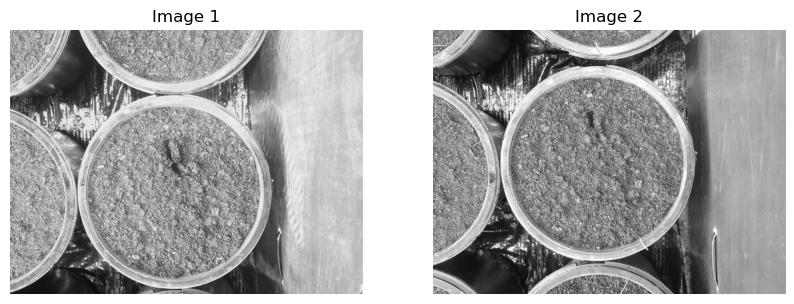

In [5]:
# Display the images side by side
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
plt.title('Image 1')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
plt.title('Image 2')
plt.axis('off')

plt.show()

In [6]:
# You can use the Image Registration technique to align your time series images. A popular algorithm for this is the Phase Correlation method. This method is based on the Fourier Shift Theorem, which states that a shift in the spatial domain corresponds to a linear phase shift in the frequency domain.

# Here's a high-level overview of the steps involved:

# Compute the Fourier Transform of both images.
# Compute the Cross-Power Spectrum: Divide the Fourier Transform of one image by the complex conjugate of the Fourier Transform of the other image.
# Compute the Inverse Fourier Transform of the Cross-Power Spectrum. This will give you a peak at the location of the shift vector.
# Find the location of the peak in the resulting image. This location corresponds to the shift between the two images.


# Compute the Fourier Transform of both images
f1 = np.fft.fft2(image1)
f2 = np.fft.fft2(image2)

# Compute the Cross-Power Spectrum
cross_power_spectrum = f1 * np.conj(f2)
cross_power_spectrum /= np.abs(cross_power_spectrum)

# Compute the Inverse Fourier Transform
shift = np.fft.ifft2(cross_power_spectrum).real

# Find the peak location
shift_y, shift_x = np.unravel_index(np.argmax(shift), shift.shape)

print(f"Shift in x: {shift_x}, Shift in y: {shift_y}")

Shift in x: 0, Shift in y: 365


In [7]:
# Crop the images so that they are aligned
image1_aligned = image1[shift_y:, shift_x:]
image2_aligned = image2[:image2.shape[0] - shift_y, :image2.shape[1] - shift_x]

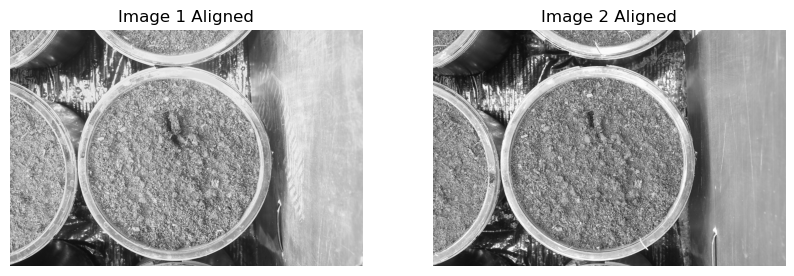

In [8]:
# display the images side by side
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image1_aligned, cv2.COLOR_BGR2RGB))
plt.title('Image 1 Aligned')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(image2_aligned, cv2.COLOR_BGR2RGB))
plt.title('Image 2 Aligned')
plt.axis('off')

plt.show()

In [10]:
# Divide the pot into 16 sectors (there is 16 seeds planted per pot in sectors of radius Xcm)

# image1_aligned_grey = cv2.cvtColor(image1_aligned, cv2.COLOR_BGR2GRAY)
image1_aligned_grey = cv2.medianBlur(image1_aligned, 5)

# Use the Hough Circle Transform to detect circles
circles = cv2.HoughCircles(image1_aligned_grey, cv2.HOUGH_GRADIENT, 1, 20, param1=50, param2=30, minRadius=0, maxRadius=0)

# Draw the circles
if circles is not None:
    circles = np.uint16(np.around(circles))
    for i in circles[0, :]:
        cv2.circle(image1_aligned, (i[0], i[1]), i[2], (0, 255, 0), 2)
        cv2.circle(image1_aligned, (i[0], i[1]), 2, (0, 0, 255), 3)

plt.imshow(cv2.cvtColor(image1_aligned, cv2.COLOR_BGR2RGB))
plt.title('Detected Circles')
plt.axis('off')
plt.show()

In [ ]:
images_gray = [cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in images]

ref_img = images_gray[0]
img = images_gray[1]

def compute_translation(reference_image, image):
    f1 = np.fft.fft2(reference_image)
    f2 = np.fft.fft2(image)

    # Compute the Cross-Power Spectrum
    cross_power_spectrum = f1 * np.conj(f2)
    cross_power_spectrum /= np.abs(cross_power_spectrum)

    # Compute the Inverse Fourier Transform
    shift = np.fft.ifft2(cross_power_spectrum).real

    # Find the peak location
    shift_y, shift_x = np.unravel_index(np.argmax(shift), shift.shape)

    print(f"Shift in x: {shift_x}, Shift in y: {shift_y}")

    return shift_x, shift_y

def align_images(image, shift_x, shift_y):
    # Create the translation matrix
    translation_matrix = np.float32([[1, 0, shift_x], [0, 1, shift_y]])

    # Translate the image
    return cv2.warpAffine(image, translation_matrix, (image.shape[1], image.shape[0]))

x_translate, y_translate = compute_translation(ref_img, img)
img = align_images(img, x_translate, y_translate)

# Display the images side by side
fig, ax = plt.subplots(1, 2, figsize=(15, 15))
ax[0].imshow(ref_img, cmap='gray')
ax[0].axis('off')
ax[0].set_title('Reference Image')

ax[1].imshow(img, cmap='gray')
ax[1].axis('off')
ax[1].set_title('Translated Image')

plt.show()

# Seems to work fantastically on the first two images but on none of the others (can ommit this step as we are identifying shoots in relation to the pot rim not the absolute position on the image)